<a href="https://colab.research.google.com/github/cweiqiang/wq.github.io/blob/main/MLS_ControlNet_Talk_Simple_with_Diffusers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q diffusers==0.14.0 transformers xformers git+https://github.com/huggingface/accelerate.git
!pip install -q opencv-contrib-python
!pip install -q controlnet_aux
!pip install -q transformers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.4/737.4 KB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 108.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 MB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 104.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 6.3 MB/s eta 0:00:00


In [ ]:
!nvidia-smi -L

GPU 0: NVIDIA A100-SXM4-40GB (UUID: GPU-74f7e6d2-1f53-b44b-2605-4c0686d66c7f)


In [ ]:
!wget -q https://www.dropbox.com/s/umeh0ptjv064lji/marina_bay_sands_001.jpg

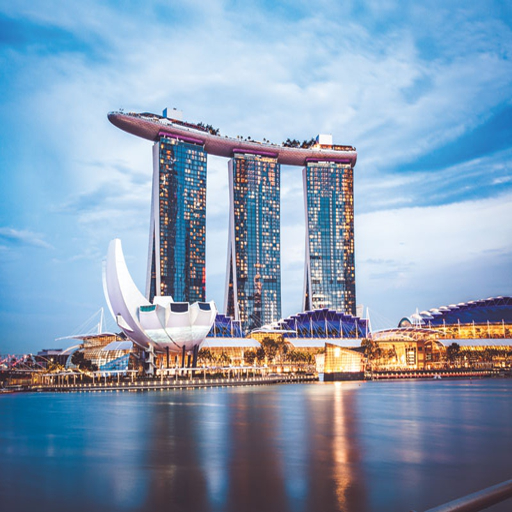

In [ ]:
from diffusers import StableDiffusionControlNetPipeline
from transformers import pipeline
from diffusers.utils import load_image

image = load_image(
    # "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
    "/content/marina_bay_sands_001.jpg"
)
image

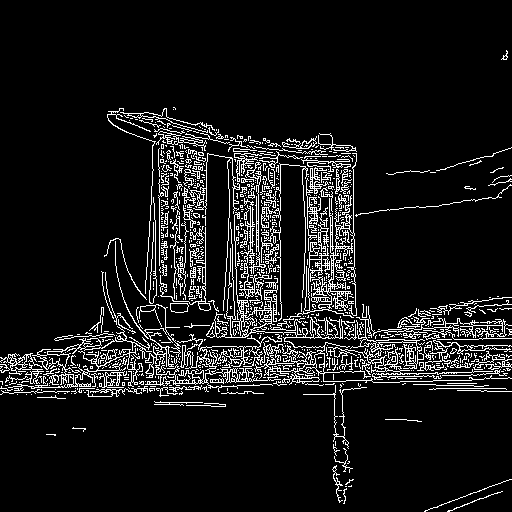

In [ ]:
# use opencv to make a canny image
import cv2
from PIL import Image
import numpy as np

image = np.array(image)

low_threshold = 100
high_threshold = 200

image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)
canny_image

In [ ]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
import torch

controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [ ]:
# scheduler
from diffusers import UniPCMultistepScheduler
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

In [ ]:
# take care of device 
pipe.enable_model_cpu_offload()
# speed up acceleration
pipe.enable_xformers_memory_efficient_attention()

In [ ]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

  0%|          | 0/20 [00:00<?, ?it/s]

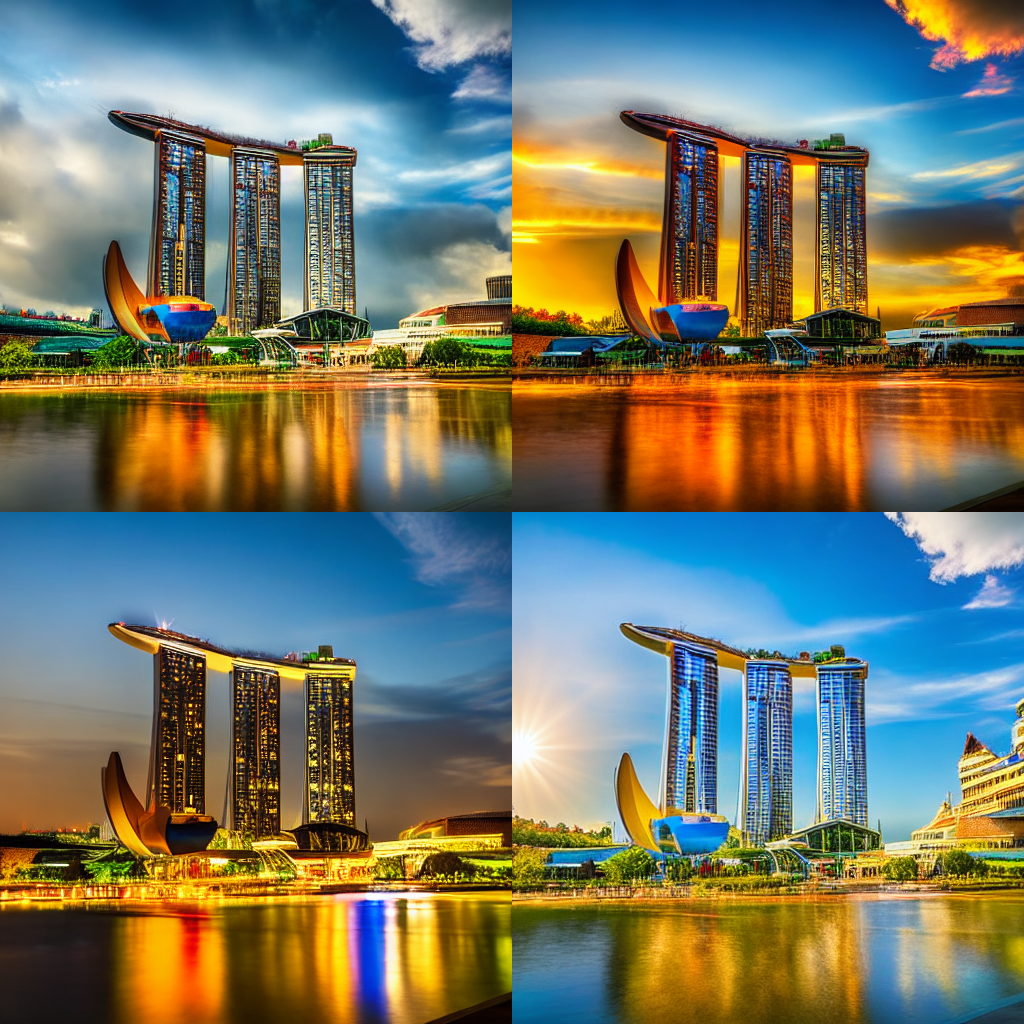

In [ ]:


prompt = "at Marina Bay Sands, best quality, extremely detailed, photo realistic"
prompt = [t + prompt for t in ["Morning", "Sunset", "Evening", "Stormy day"]]
generator = [torch.Generator(device="cpu").manual_seed(2) for i in range(len(prompt))]

output = pipe(
    prompt,
    canny_image,
    negative_prompt=["monochrome, lowres, bad anatomy, worst quality, low quality"] * len(prompt),
    generator=generator,
    num_inference_steps=20,
)

image_grid(output.images, 2, 2)

## OpenPose

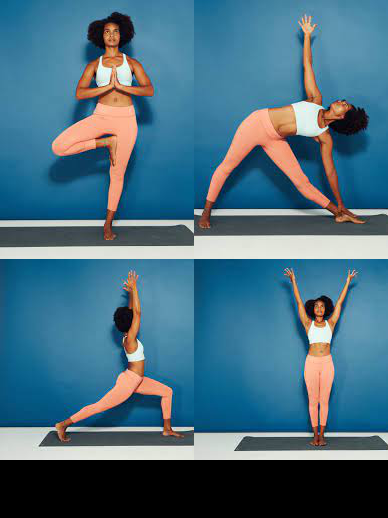

In [ ]:
urls = "yoga1.jpeg", "yoga2.jpeg", "yoga3.jpeg", "yoga4.jpeg"
imgs = [
    load_image("https://hf.co/datasets/YiYiXu/controlnet-testing/resolve/main/" + url) 
    for url in urls
]

image_grid(imgs, 2, 2)

cuda


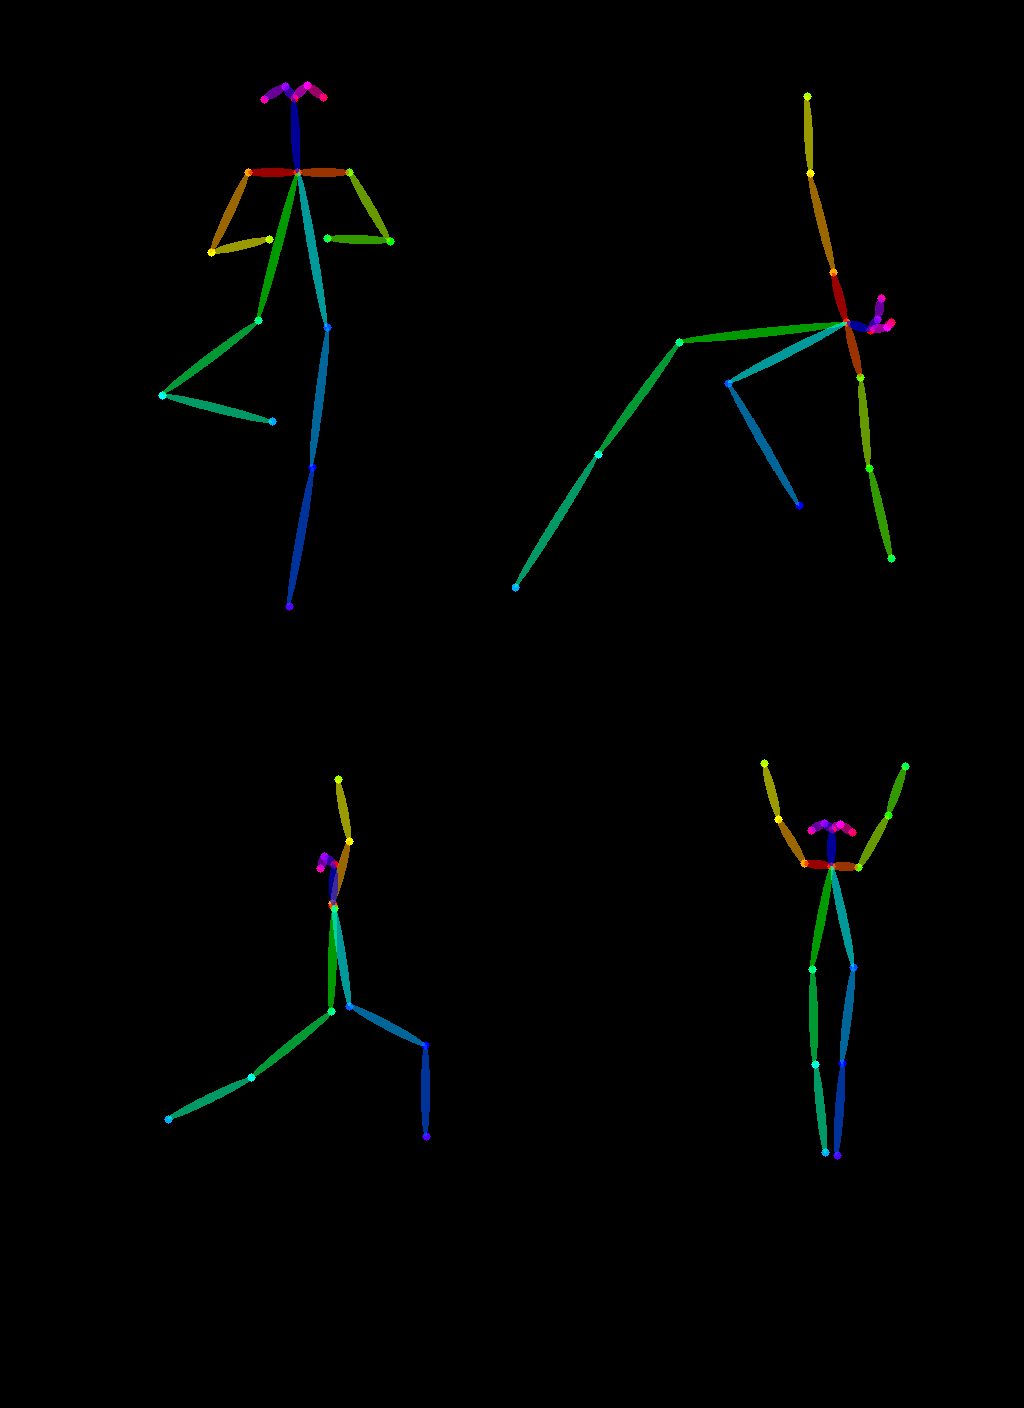

In [ ]:
from controlnet_aux import OpenposeDetector

model = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

poses = [model(img) for img in imgs]
image_grid(poses, 2, 2)

In [ ]:
controlnet = ControlNetModel.from_pretrained(
    "fusing/stable-diffusion-v1-5-controlnet-openpose", torch_dtype=torch.float16
)

model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    model_id,
    controlnet=controlnet,
    torch_dtype=torch.float16,
)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()
pipe.enable_xformers_memory_efficient_attention()

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

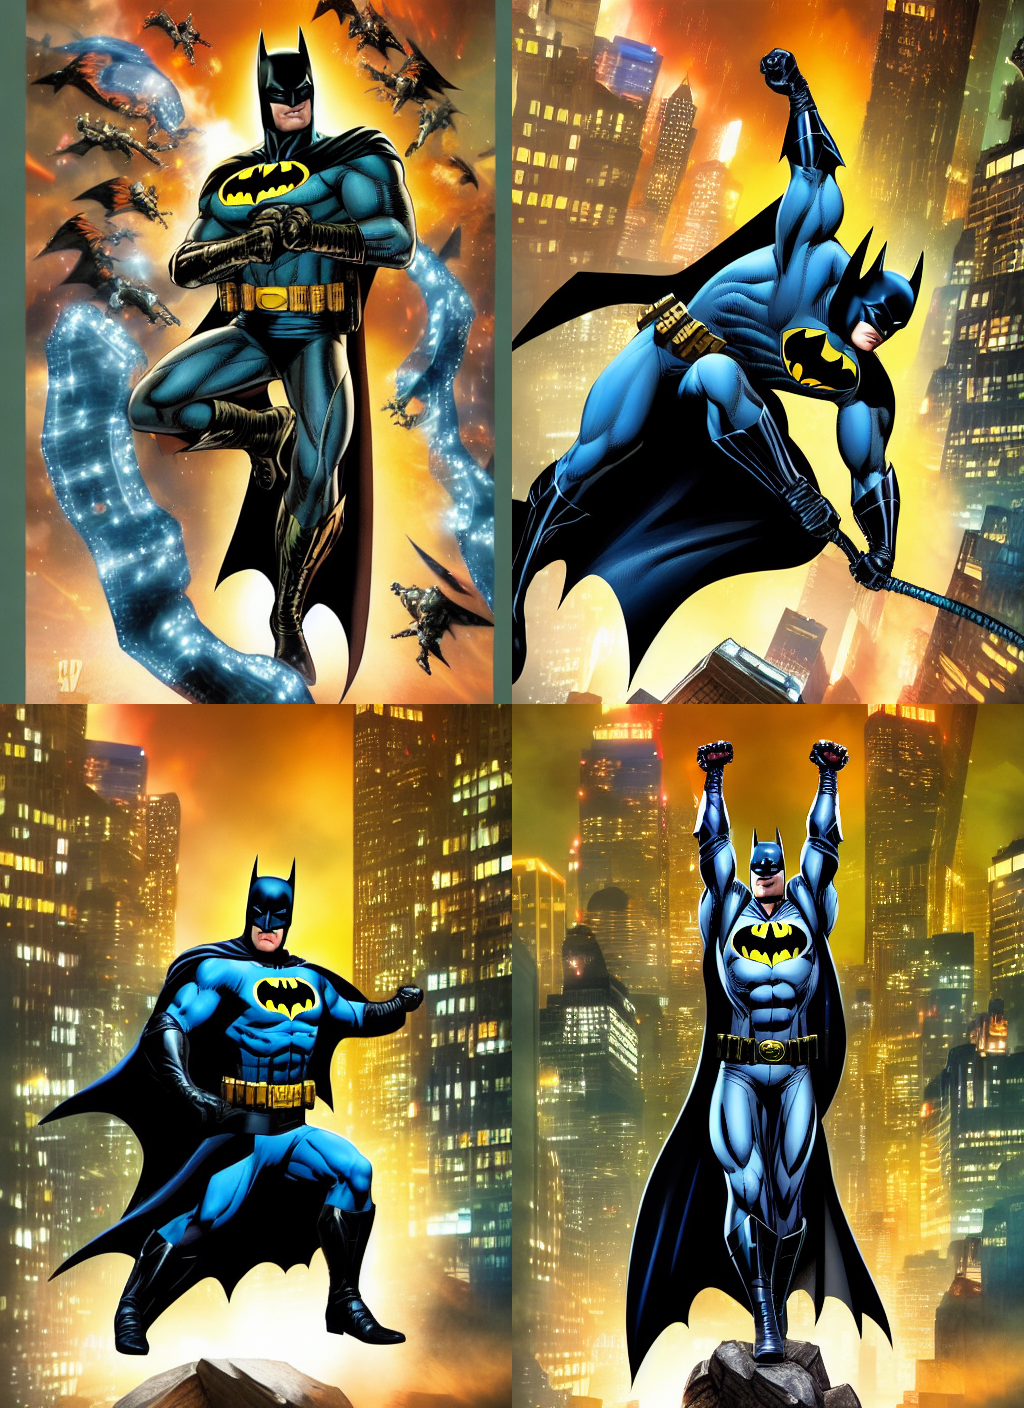

In [ ]:
generator = [torch.Generator(device="cpu").manual_seed(2) for i in range(4)]
prompt = "Batman character, best quality, extremely detailed"
output = pipe(
    [prompt] * 4,
    poses,
    negative_prompt=["monochrome, lowres, bad anatomy, worst quality, low quality"] * 4,
    generator=generator,
    num_inference_steps=20,
)
image_grid(output.images, 2, 2)

## Hough for logo

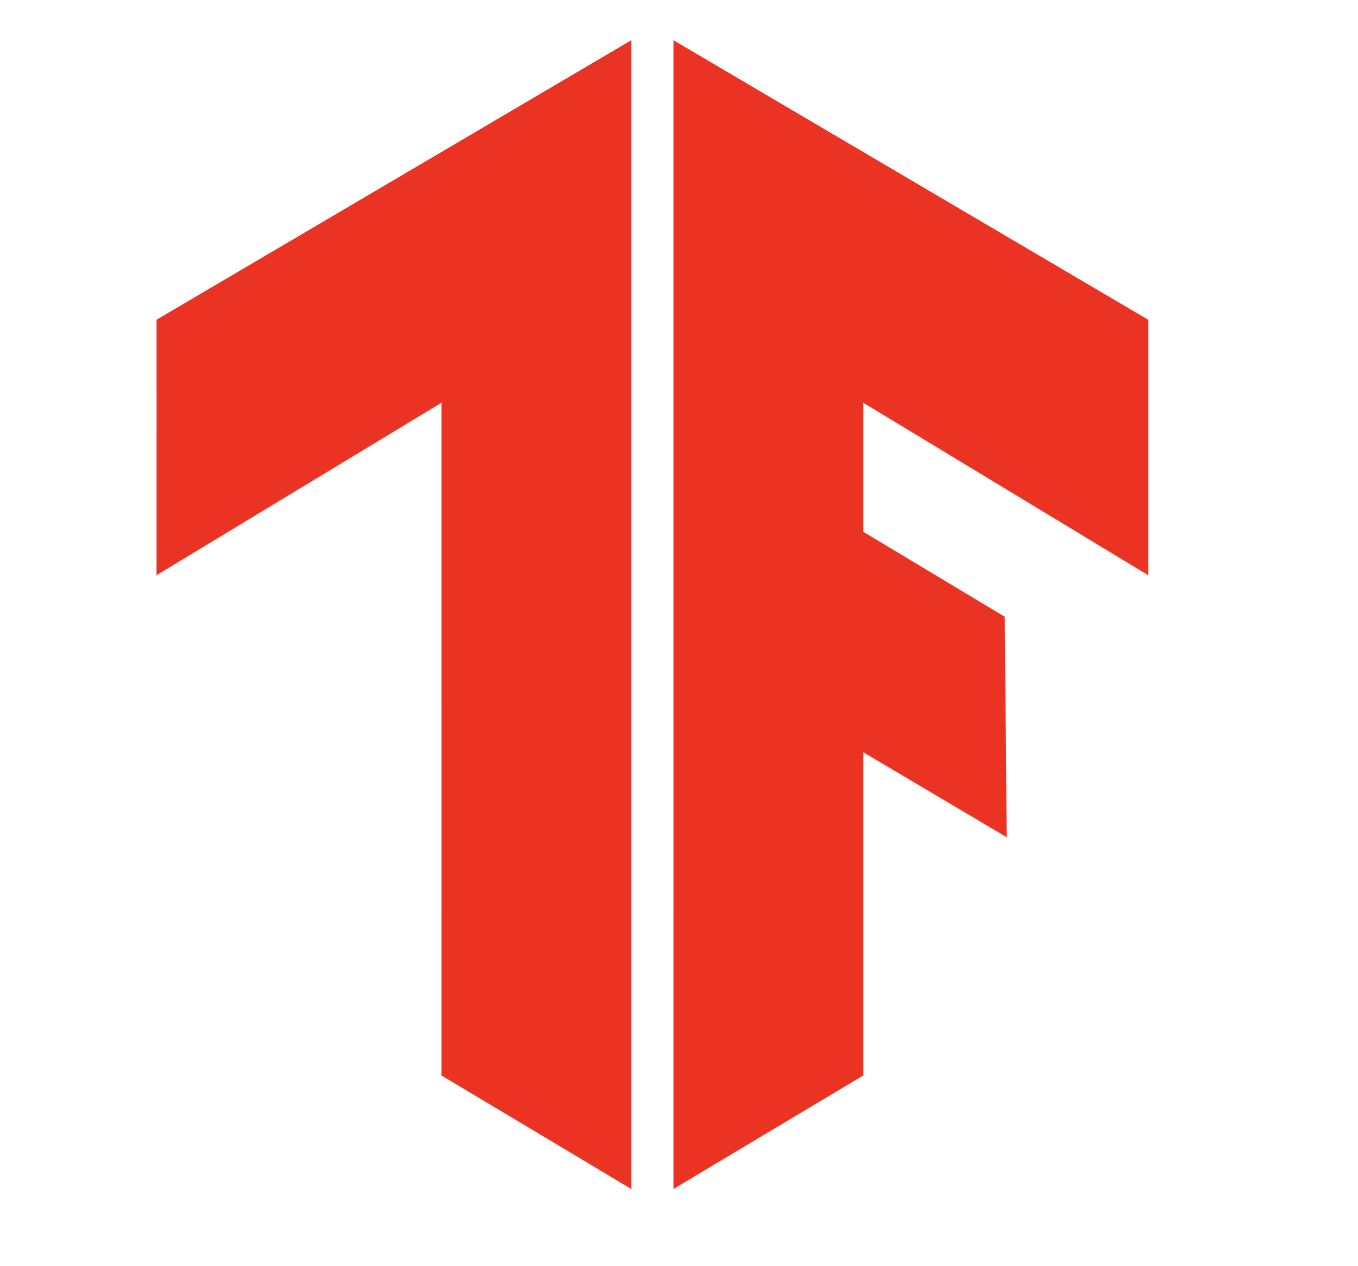

In [ ]:
image = load_image(
    "tf_logo.png"
)
image

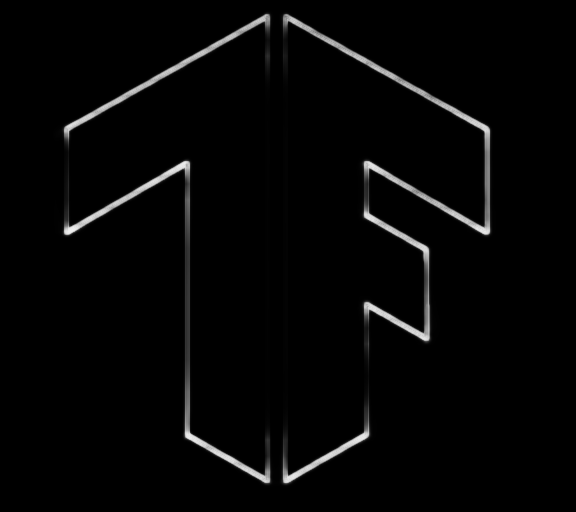

In [ ]:
from controlnet_aux import HEDdetector

model = HEDdetector.from_pretrained("lllyasviel/ControlNet")

img = model(image)
img

In [ ]:

controlnet = ControlNetModel.from_pretrained(
    "fusing/stable-diffusion-v1-5-controlnet-hed", torch_dtype=torch.float16
)

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, safety_checker=None, torch_dtype=torch.float16
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# Remove if you do not have xformers installed
# see https://huggingface.co/docs/diffusers/v0.13.0/en/optimization/xformers#installing-xformers
# for installation instructions
pipe.enable_xformers_memory_efficient_attention()

pipe.enable_model_cpu_offload()

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
image = pipe("a golden coin", img, num_inference_steps=20).images[0]
# image = pipe("pattern visible in the sand on a sandy beach with the sea around", img, num_inference_steps=20).images[0]

  0%|          | 0/20 [00:00<?, ?it/s]

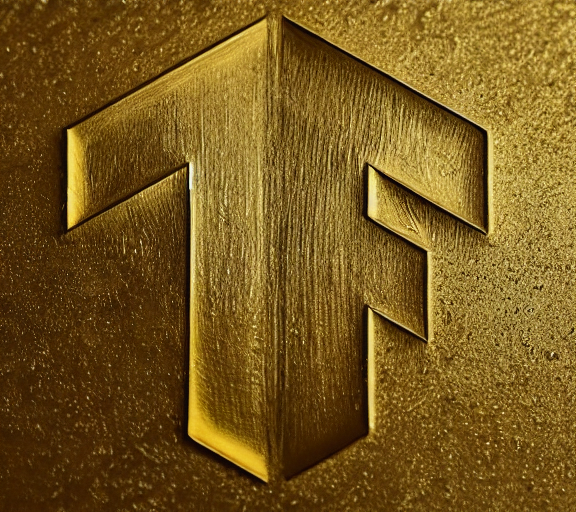

In [ ]:
image

## Normal Map

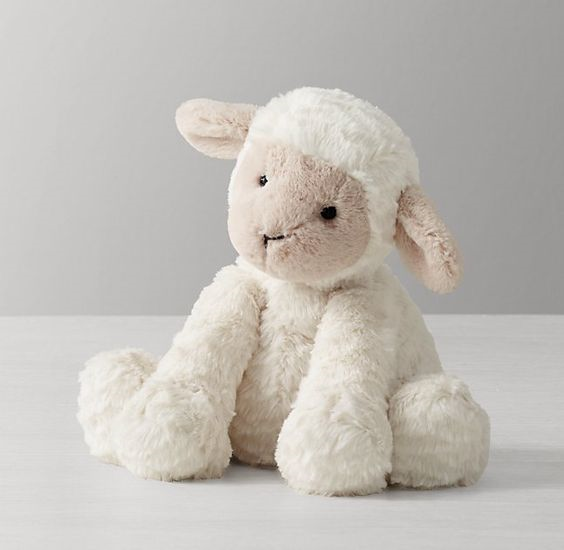

In [ ]:
image = load_image("https://huggingface.co/lllyasviel/sd-controlnet-normal/resolve/main/images/toy.png").convert("RGB")
image

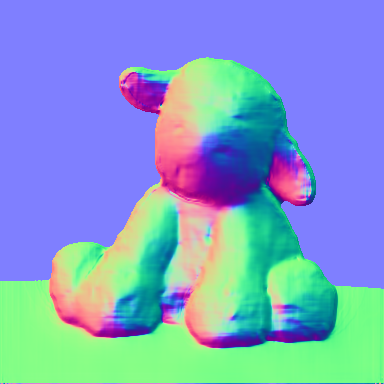

In [ ]:
depth_estimator = pipeline("depth-estimation", model ="Intel/dpt-hybrid-midas" )

image = depth_estimator(image)['predicted_depth'][0]

image = image.numpy()

image_depth = image.copy()
image_depth -= np.min(image_depth)
image_depth /= np.max(image_depth)

bg_threhold = 0.4

x = cv2.Sobel(image, cv2.CV_32F, 1, 0, ksize=3)
x[image_depth < bg_threhold] = 0

y = cv2.Sobel(image, cv2.CV_32F, 0, 1, ksize=3)
y[image_depth < bg_threhold] = 0

z = np.ones_like(x) * np.pi * 2.0

image = np.stack([x, y, z], axis=2)
image /= np.sum(image ** 2.0, axis=2, keepdims=True) ** 0.5
image = (image * 127.5 + 127.5).clip(0, 255).astype(np.uint8)
image = Image.fromarray(image)
image

In [ ]:
controlnet = ControlNetModel.from_pretrained(
    "fusing/stable-diffusion-v1-5-controlnet-normal", torch_dtype=torch.float16
)

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, safety_checker=None, torch_dtype=torch.float16
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_xformers_memory_efficient_attention()

pipe.enable_model_cpu_offload()

image = pipe("cute toy", image, num_inference_steps=20).images[0]


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/20 [00:00<?, ?it/s]

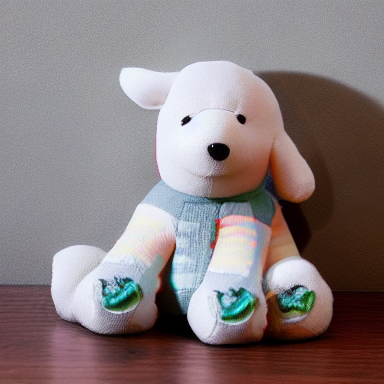

In [ ]:
image

## depth example

No model was supplied, defaulted to Intel/dpt-large and revision e93beec (https://huggingface.co/Intel/dpt-large).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


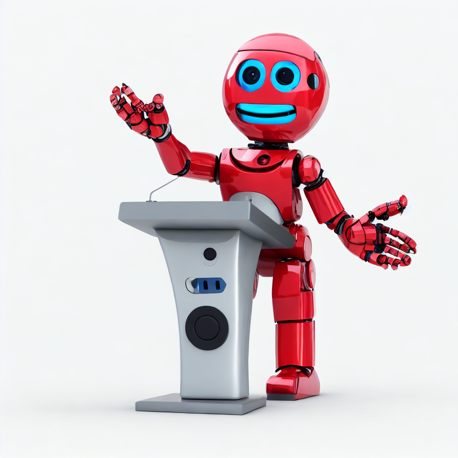

In [ ]:
depth_estimator = pipeline('depth-estimation')

image = load_image("https://huggingface.co/lllyasviel/sd-controlnet-depth/resolve/main/images/stormtrooper.png")
image

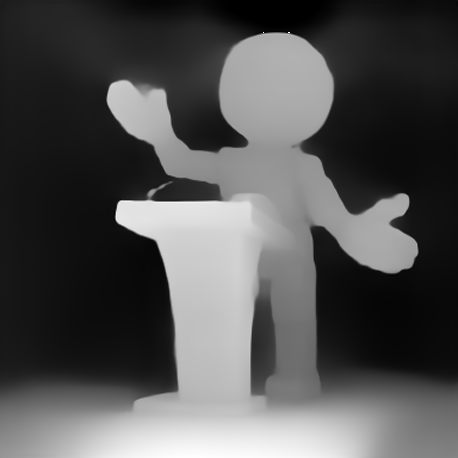

In [ ]:
image = depth_estimator(image)['depth']
image = np.array(image)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
image = Image.fromarray(image)

image

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/20 [00:00<?, ?it/s]

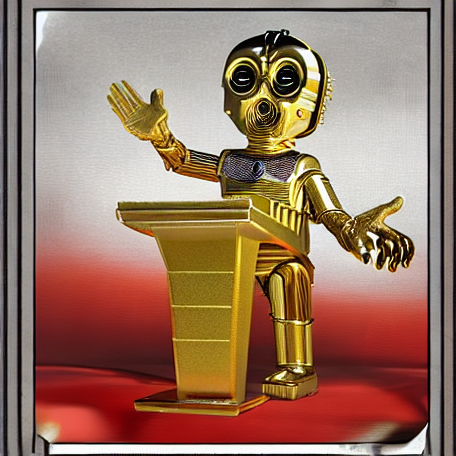

In [ ]:
controlnet = ControlNetModel.from_pretrained(
    "fusing/stable-diffusion-v1-5-controlnet-depth", torch_dtype=torch.float16
)

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, safety_checker=None, torch_dtype=torch.float16
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_xformers_memory_efficient_attention()
pipe.enable_model_cpu_offload()

image = pipe("C3PO", image, num_inference_steps=20).images[0]

image